In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from datetime import date

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, PoissonRegressor, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings("ignore")

print('Import Finished')

Import Finished


In [2]:
#Reading in the data
X_train = pd.read_csv('dengue_features_train.csv')
y_train = pd.read_csv('dengue_labels_train.csv')
X_test = pd.read_csv('dengue_features_test.csv')
df_train = pd.concat([X_train, y_train.total_cases], axis = 1)

In [3]:
X_train

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [4]:
y_train

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


# EDA

In [5]:
X_train.dtypes

city                                      object
year                                       int64
weekofyear                                 int64
week_start_date                           object
ndvi_ne                                  float64
ndvi_nw                                  float64
ndvi_se                                  float64
ndvi_sw                                  float64
precipitation_amt_mm                     float64
reanalysis_air_temp_k                    float64
reanalysis_avg_temp_k                    float64
reanalysis_dew_point_temp_k              float64
reanalysis_max_air_temp_k                float64
reanalysis_min_air_temp_k                float64
reanalysis_precip_amt_kg_per_m2          float64
reanalysis_relative_humidity_percent     float64
reanalysis_sat_precip_amt_mm             float64
reanalysis_specific_humidity_g_per_kg    float64
reanalysis_tdtr_k                        float64
station_avg_temp_c                       float64
station_diur_temp_rn

All features provided are numeric, except for `city` and `week_start_date`

For this project, we'll focus on dengue fever cases in San Juan (SJ). 

In [6]:
#Filter only SJ rows of df_train, X_train, y_train, and X_test

df_train_sj = df_train.loc[df_train.city == 'sj']

X_train_sj = X_train.loc[X_train.city == 'sj']

y_train_sj = y_train.loc[y_train.city == 'sj'].join(X_train_sj['week_start_date'], how = 'left')
y_train_labels_sj = y_train_sj.total_cases

X_test_sj = X_test.loc[X_test.city == 'sj']

In [7]:
#Understanding the training dataset

n_sj = X_train_sj.city.count()

earliest_date_sj = X_train_sj.week_start_date.min()
latest_date_sj = X_train_sj.week_start_date.max()

print('There are {} observations in the training dataset'.format(n_sj))
print()
print('The dates in the training set range from {} to {}'.format(earliest_date_sj, latest_date_sj))

There are 936 observations in the training dataset

The dates in the training set range from 1990-04-30 to 2008-04-22


In [1768]:
X_train_sj.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,936.000000,936.000000,745.000000,887.000000,917.000000,917.000000,927.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,927.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000
mean,1998.826923,26.503205,0.057925,0.067469,0.177655,0.165956,35.470809,299.163653,299.276920,295.109519,301.398817,297.301828,30.465419,78.568181,35.470809,16.552409,2.516267,27.006528,6.757373,31.607957,22.600645,26.785484
std,5.212076,15.021909,0.107153,0.092479,0.057166,0.056073,44.606137,1.236429,1.218637,1.569943,1.258927,1.294705,35.628055,3.389488,44.606137,1.560923,0.498892,1.415473,0.835993,1.717297,1.506277,29.325811
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,295.938571,296.114286,289.642857,297.800000,292.600000,0.000000,66.735714,0.000000,11.715714,1.357143,22.842857,4.528571,26.700000,17.800000,0.000000
25%,1994.000000,13.750000,0.004500,0.016425,0.139283,0.129157,0.000000,298.195000,298.300000,293.847857,300.400000,296.300000,10.825000,76.246071,0.000000,15.236429,2.157143,25.842857,6.200000,30.600000,21.700000,6.825000
50%,1999.000000,26.500000,0.057700,0.068075,0.177186,0.165971,20.800000,299.254286,299.378571,295.464286,301.500000,297.500000,21.300000,78.667857,20.800000,16.845714,2.457143,27.228571,6.757143,31.700000,22.800000,17.750000
75%,2003.000000,39.250000,0.111100,0.115200,0.212557,0.202771,52.180000,300.132857,300.228571,296.418929,302.400000,298.400000,37.000000,80.963214,52.180000,17.858571,2.800000,28.185714,7.285714,32.800000,23.900000,35.450000
max,2008.000000,53.000000,0.493400,0.437100,0.393129,0.381420,390.600000,302.200000,302.164286,297.795714,304.300000,299.900000,570.500000,87.575714,390.600000,19.440000,4.428571,30.071429,9.914286,35.600000,25.600000,305.900000


In [1770]:
y_train_sj.describe()

,year,weekofyear,total_cases
count,936.000000,936.000000,936.000000
mean,1998.826923,26.503205,34.180556
std,5.212076,15.021909,51.381372
min,1990.000000,1.000000,0.000000
25%,1994.000000,13.750000,9.000000
50%,1999.000000,26.500000,19.000000
75%,2003.000000,39.250000,37.000000
max,2008.000000,53.000000,461.000000


#### Missing Data

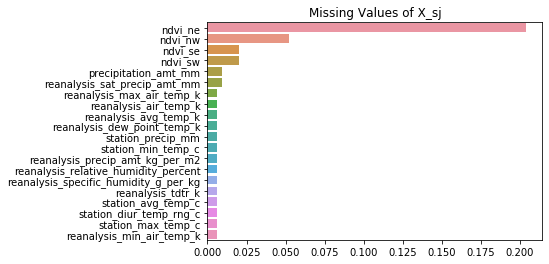

In [1774]:
# Percent of values missing from each variable

x = (X_train_sj.iloc[:, 4:].isnull().sum() / len(X_train_sj)).sort_values(ascending=False)
y = x.index
sns.barplot(x = x, y = y)
plt.title('Missing Values of X_sj')
plt.show()

The NDVI variables have the highest percent of missing data. All other variables are missing less than 1% of values. 

In [1776]:
# Examining data points with NaN for all climate-related variables

X_train_sj[X_train_sj.iloc[:, 4:].isnull().all(axis=1)]

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
139,sj,1993,53,1993-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,sj,1999,53,1999-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
763,sj,2005,53,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1778]:
X_train_sj[X_train_sj.year == 2004][['weekofyear', 'week_start_date']]

,weekofyear,week_start_date
711,1,2004-01-01
712,2,2004-01-08
713,3,2004-01-15
714,4,2004-01-22
715,5,2004-01-29
...,...,...
758,48,2004-11-25
759,49,2004-12-02
760,50,2004-12-09
761,51,2004-12-16


In [1779]:
X_train_sj[X_train_sj.year == 2005][['weekofyear', 'week_start_date']]

,weekofyear,week_start_date
763,53,2005-01-01
764,1,2005-01-08
765,2,2005-01-15
766,3,2005-01-22
767,4,2005-01-29
...,...,...
810,47,2005-11-26
811,48,2005-12-03
812,49,2005-12-10
813,50,2005-12-17


Week 53 occurrs in `weekofyear` in some years is due to the ISO standard. All `weekofyear` values of 53 have a `week_start_date` of 01/01 and contain 52 total weeks, with the last week being 51. All years, except for those at the beginning and end of the dataset for each city (1990 and 2008 for SJ, 2000 and 2010 for IQ) contain 52 weeks. Feature engineering `weekofyear` so that 53 becomes 1 and all others are increased by 1.

#### Distributions of Variables and Relationship to Total Cases

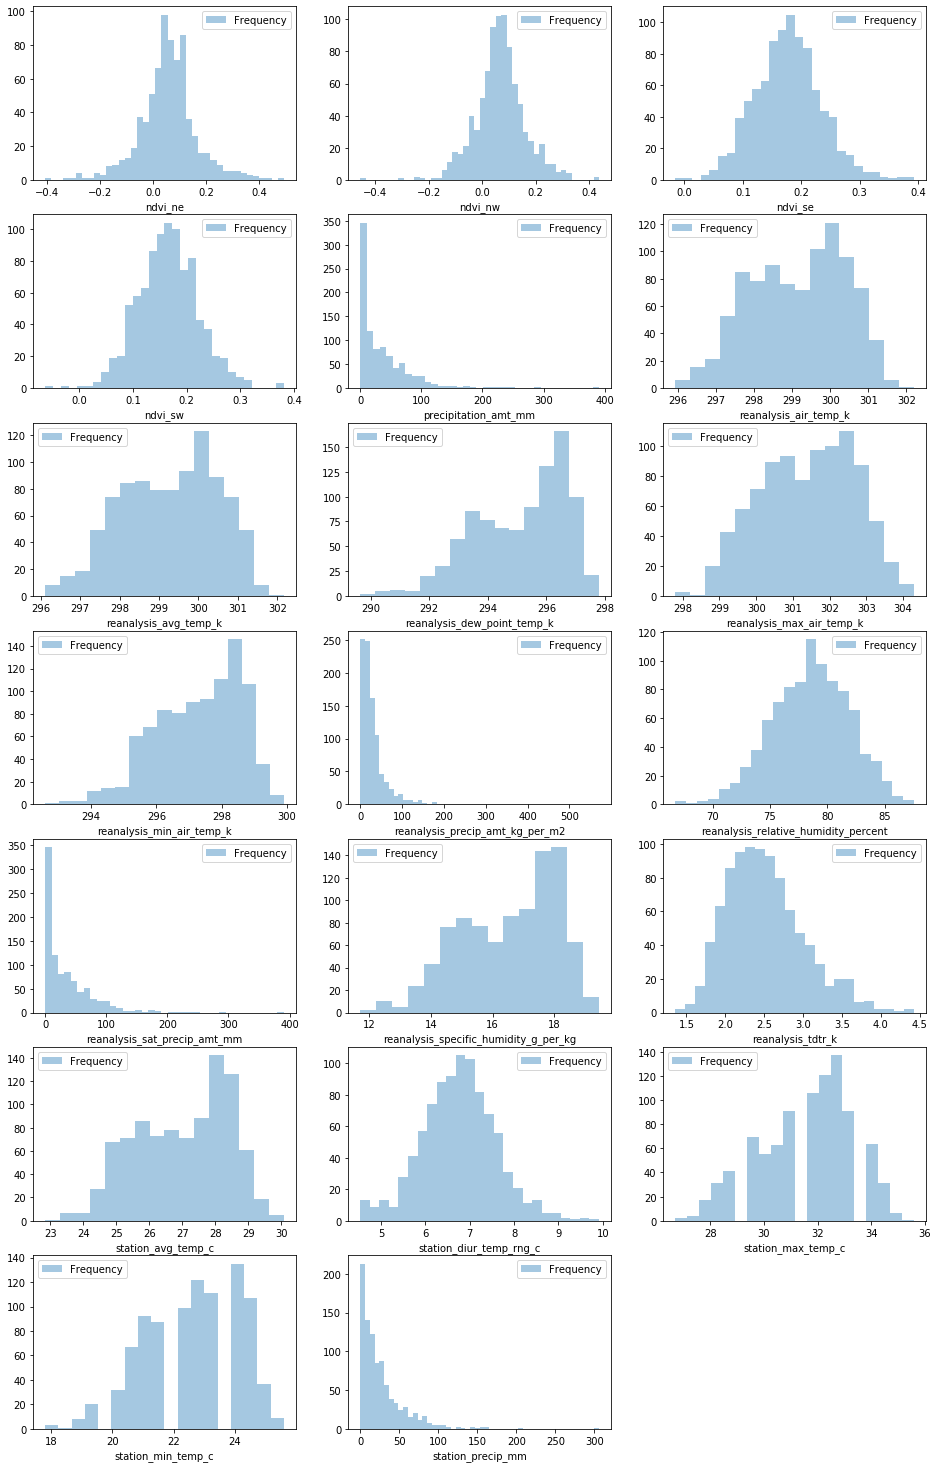

In [12]:
#Distribution of values of each variable

fig = plt.figure(figsize=(16,30))
i = 0
for col in X_train_sj.columns[4:]:
    i+=1
    fig.add_subplot(8,3,i)
    sns.distplot(a=X_train_sj[X_train_sj[col].notnull()][col], kde = False, label = 'Frequency')
    plt.legend()

Examining these histograms, we are able to see the distribution of values of each variable. For example, `precipitation_amount_mm` is highly concentrated at 0. The long tail of `precipitation_amount_mm` could indicate that a rainy and dry season exist. NDVI stands for normalized vegetation difference index and measures the density of green on a patch of land. Values range from -1 to 1, where 1 is fully green and 0 is no vegetation. 

These historgrams also provide insight into feature characteristics as well. Some of these features measure the same or correlated attributes. For example, `reanalysis_sat_precip_amt_mm` and `station_precip_mm` measure total precipitation in the city but come from different sources. As mentioned previously `precipitation_amount_mm` is highly concentrated at 0 and therefore our model may benefit from a transformation. As a result, we will likely be able to improve our model's performance by utilizing feature engineering and/or feature selection.

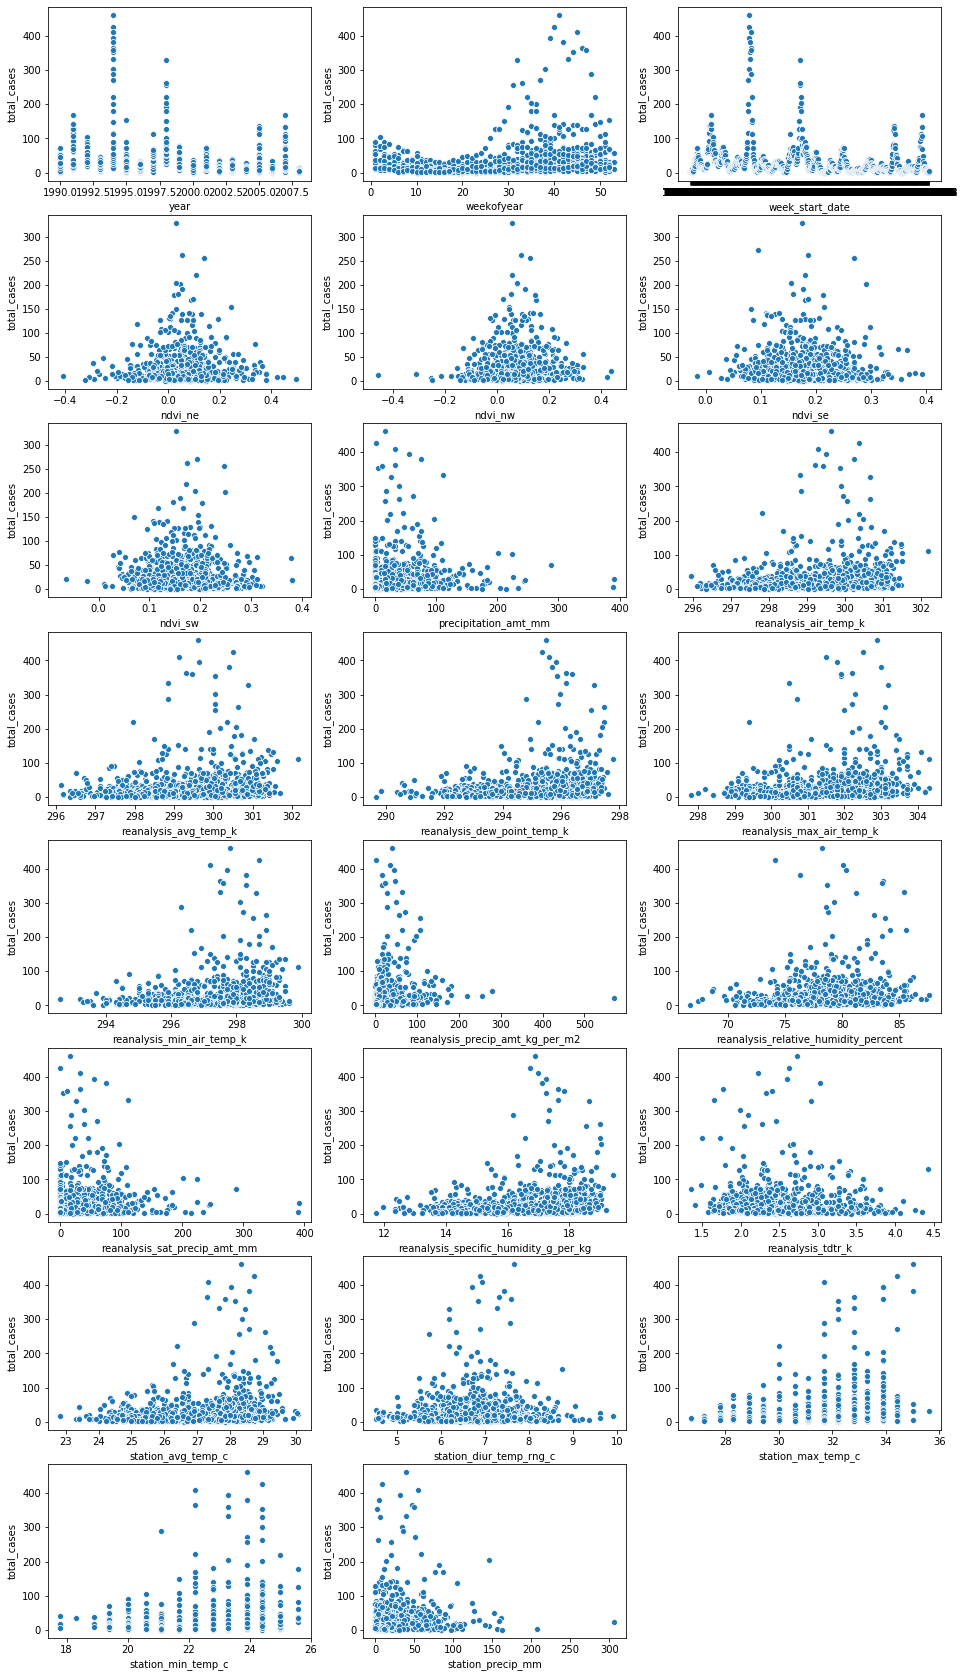

In [11]:
#Pairwise plots of each variable

fig = plt.figure(figsize=(16,30))
i = 0
for col in X_train_sj.columns.drop('city'):
    i += 1
    fig.add_subplot(8,3,i)
    sns.scatterplot(x=df_train_sj[col], y=df_train_sj["total_cases"])

#### Correlations Exploration

In [1785]:
#Correlation of variables with total_cases

df_train_sj.corr()['total_cases'].sort_values()

year                                    -0.212690
reanalysis_tdtr_k                       -0.067600
ndvi_sw                                 -0.000333
ndvi_se                                  0.001113
station_diur_temp_rng_c                  0.034630
ndvi_ne                                  0.037639
station_precip_mm                        0.051759
precipitation_amt_mm                     0.060211
reanalysis_sat_precip_amt_mm             0.060211
ndvi_nw                                  0.075307
reanalysis_precip_amt_kg_per_m2          0.107457
reanalysis_relative_humidity_percent     0.144045
reanalysis_avg_temp_k                    0.175267
station_min_temp_c                       0.177012
reanalysis_air_temp_k                    0.181917
reanalysis_min_air_temp_k                0.187943
station_max_temp_c                       0.189901
reanalysis_max_air_temp_k                0.194532
station_avg_temp_c                       0.196617
reanalysis_dew_point_temp_k              0.203774


None of the variables strongly correlate with `total_cases` and all but three of the correlations are positive. Also, `weekofyear`, which in a way encapsulates many of these variables, is surprisingly the strongest predictor. Temperature and humidity-related variables somewhat strongly correlate with `total_cases` whereas precipitation-related and NDVI variables are weak correlators. The weak correlation of precipitation-related variables in SJ could be related to the high number of weeks with 0 values.

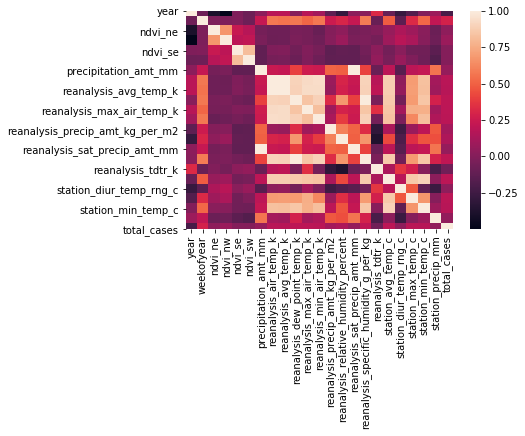

In [1786]:
#Correlation heatmap

sns.heatmap(df_train_sj.corr())

In [1787]:
#Strong correlations between variables expressed in a dictionary

sj_corr_dict = {}
for col in df_train_sj.corr().columns:
    sj_corr_dict[col] = [(idx, df_train_sj.corr()[col][idx]) for idx in df_train_sj.corr().columns if idx != col and abs(df_train_sj.corr()[col][idx]) >= .6]
    
sj_corr_dict

C:\Users\ellio\Anaconda3\lib\site-packages\IPython\core\displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


{'year': [],
 'weekofyear': [],
 'ndvi_ne': [('ndvi_nw', 0.6730370912362169)],
 'ndvi_nw': [('ndvi_ne', 0.6730370912362169)],
 'ndvi_se': [('ndvi_sw', 0.8213540520802144)],
 'ndvi_sw': [('ndvi_se', 0.8213540520802144)],
 'precipitation_amt_mm': [('reanalysis_sat_precip_amt_mm', 1.0)],
 'reanalysis_air_temp_k': [('reanalysis_avg_temp_k', 0.9974952432829403),
  ('reanalysis_dew_point_temp_k', 0.9032871230982901),
  ('reanalysis_max_air_temp_k', 0.935088959026492),
  ('reanalysis_min_air_temp_k', 0.9422536353865085),
  ('reanalysis_specific_humidity_g_per_kg', 0.9048189392495243),
  ('station_avg_temp_c', 0.880930948014158),
  ('station_max_temp_c', 0.697948599077625),
  ('station_min_temp_c', 0.8328632546055222)],
 'reanalysis_avg_temp_k': [('reanalysis_air_temp_k', 0.9974952432829403),
  ('reanalysis_dew_point_temp_k', 0.895122758424718),
  ('reanalysis_max_air_temp_k', 0.9389516028711338),
  ('reanalysis_min_air_temp_k', 0.9391201588703382),
  ('reanalysis_specific_humidity_g_per_kg', 

We see that strong positive correlations exist between `ndvi_ne` and `ndvi_nw` as well as `ndvi_se` and `ndvi_sw`. Interestingly, the correlations are weaker between north and south pixels. A perfect positive linear relationship exists between `precipitation_amt_mm` and `reanalysis_sat_precip_amt_mm`. Therefore, we should eliminate one of these variables when we begin modeling. We also see strong positive correlations between the temperature-related variables (`reanalysis_avg_temp_k`, `reanalysis_max_air_temp_k`, `reanalysis_air_temp_k`, `reanalysis_dew_point_temp_k`, `reanalysis_min_air_temp_k`, `reanalysis_specific_humidity_g_per_kg`, `station_avg_temp_c`, `station_max_temp_c`, `station_min_temp_c`). However, `reanalysis_specific_humidity_g_per_kg` and `reanalysis_relative_humidity_percent` do not correlate as strongly (~0.67) as the temperature-related variables and even `reanalysis_specific_humidity_g_per_kg` with the temperature-related variables.

#### Total Cases Exploration

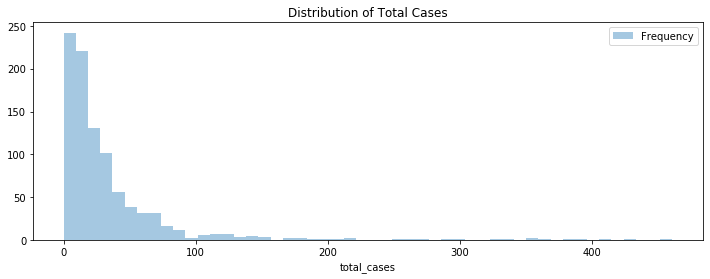

In [21]:
#Distribution of total cases

fig = plt.figure(figsize=(12,4))
sns.distplot(a=y_train_sj['total_cases'], kde = False, label = 'Frequency')
plt.title('Distribution of Total Cases')
plt.legend()

The total cases has a high concentration of low-valued numbers, is non-negative, contains a long right tail, and is discrete, count data. This indicates that the target, `total_cases`, follows a Negative Binomial or Poisson distribution (if errors' mean = variance). 

Text(0.5, 1.0, 'CDF of Cases')

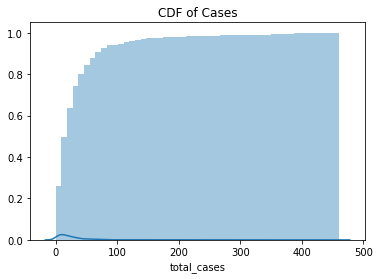

In [19]:
#Cumulative density of occurrences of total cases

kwargs = {'cumulative': True}

sns.distplot(y_train_sj['total_cases'], hist_kws=kwargs, label = 'Cumulative Percent of Total Cases')
plt.title('CDF of Cases')

In [27]:
#Total cases statistics

percent_zero_sj = (y_train_labels_sj == 0).sum() / y_train_sj.shape[0]
percent_five_or_lower_sj = (y_train_labels_sj <= 5).sum() / y_train_sj.shape[0]

print('Median cases: {:.1f}. Mean cases: {:.1f}. Variance of cases: {:.1f}'.format(y_train_sj['total_cases'].median(), y_train_sj['total_cases'].mean(), y_train_sj['total_cases'].var()))
print('{:.2%} of weeks recorded 5 cases or fewer'.format(percent_five_or_lower_sj))

Median cases: 19.0. Mean cases: 34.2. Variance of cases: 2640.0
13.57% of weeks recorded 5 cases or fewer


Text(0.5, 1.0, 'Total Cases by Month')

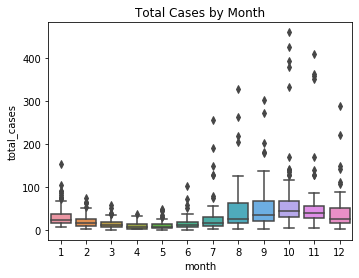

In [30]:
#Boxplots of total_cases by month

fig = plt.figure(figsize=(12,4))

sj_week_start_date = pd.to_datetime(y_train_sj.week_start_date)
y_train_sj['month'] = sj_week_start_date.map(lambda x: x.month)

fig.add_subplot(1,2,1)
sns.boxplot(x = y_train_sj.month, y = y_train_labels_sj)
plt.title('Total Cases by Month')

There are months with lower and less variable `total_cases` and months with higher average `total_cases` that contain large outliers. It appears that half of the months belong to one group and half to the other. Also, these months are consecutive, indicating that there are two seasons of dengue fever infection and that weather features are likely a major contributor to the spread. The low spread and low variability season lasts from February through June and the higher spread, high variability season goes from July through January. 

Text(0.5, 1.0, 'Total Cases by Year')

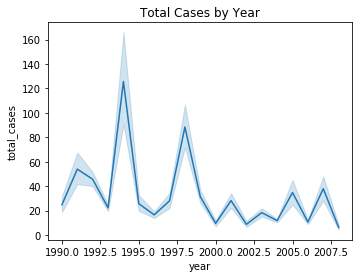

In [35]:
#Line chart of total_cases by year

fig = plt.figure(figsize=(12,4))

fig.add_subplot(1,2,1)
plot = sns.lineplot(x = y_train_sj.year, y = y_train_labels_sj)
# plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Total Cases by Year')

The line chart of `total_cases` by year display a couple of important aspects of the data. First, dengue fever appears to spike quite frequently, especially in the 1990's. Second, variance is higher in the peak years than the valley years. This tracks with our understanding of dengue fever as it is contagious (with mosquitos being the carriers of the virus) and so the spread is exacerbated by not only weather conditions, but also by the number of carriers. These factors will be important in feature engineering to improve the prediction power of the models.

# Preliminary Feature Engineering, Preprocessing, and Modeling

### Preprocessing and Feature Engineering

In [96]:
#Adding month and day features from week_start_date

sj_week_start_date = pd.to_datetime(X_train_sj.week_start_date)
X_train_sj['day'] = sj_week_start_date.map(lambda x: x.day)
X_train_sj['month'] = sj_week_start_date.map(lambda x: x.month)

In [37]:
#Returning years that contain week 53

def years_with_53_weeks(df):
    return list(df.loc[df.weekofyear == 53].year.unique())

sj_train_years_with_53 = years_with_53_weeks(X_train_sj)

print('Years {} contain week 53'.format(sj_train_years_with_53))

Years [1993, 1999, 2005] contain week 53


In [38]:
#Creating function that changes week 53 to week 1 and adds 1 to all other weekofyear in the years this occurs

def weekofyear_function(row, years_with_53):
    #adds 1 to all other weeks during a year where week 53 is present
    if ((row.year in years_with_53) and ((row.day!=1) or (row.month!=1))):
        row.weekofyear = row.weekofyear+1
    #changes week 53 to week 1
    elif (row.year in years_with_53) and (row.weekofyear == 53):
        row.weekofyear = 1
    return row

In [39]:
#Implementing weekofyear_function on X_train_sj and X_train_iq data sets

X_train_sj_feat_eng = X_train_sj.apply(lambda x: weekofyear_function(x, sj_train_years_with_53), axis = 'columns')

In [48]:
#Preprocessing pipeline

knn_imputer = KNNImputer(weights = 'distance')
std_scaler = StandardScaler()

#only keep columns with numeric data
X_sj = X_train_sj_feat_eng.select_dtypes(include=['float64', 'int64'])

#only step in pipeline is to impute missing values based on "nearest" data points
preprocessor_pipeline = Pipeline(steps = [
    ('impute', knn_imputer),
    ('scaler', std_scaler)
])

preprocessor_pipeline.fit_transform(X_sj)[0]

array([-1.69445772, -0.56635211,  0.6531925 ,  0.40139453,  0.36941125,
        0.21287358, -0.51111096, -1.28354902, -1.25538065, -1.71477558,
       -1.26530873, -1.07675909,  0.04581668, -1.53767398, -0.51111096,
       -1.62467081,  0.22899895, -1.09641384,  0.1716734 , -1.27818981,
       -1.71786892, -0.3671755 ,  1.68112446, -0.70087948])

### Modeling

#### Baseline Model

In [50]:
#Baseline model

from sklearn.dummy import DummyRegressor

#TimeSeriesSplit is a method of cross validation that prevents data leakage that can arise when using k-fold cv on time series data
tscv = TimeSeriesSplit(n_splits=2)

dummy_model = DummyRegressor(strategy='mean')

sj_dummy_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model', dummy_model)
])

cv_dummy_sj = cross_val_score(sj_dummy_pipeline, X_sj, y_train_labels_sj, scoring = 'neg_mean_absolute_error', cv=tscv)
print('MAE for {} is {:.3f}'.format(dummy_model, abs(cv_dummy_sj.mean())))

SJ: MAE for DummyRegressor() is 31.387


The Dummy Regressor serves as a baseline model as we test different models to find the one best for the dataset. It is invariant to preprocessing as it solely relies on the labels, which have not been transformed or changed in any way.

#### Poisson Regression

In [123]:
#Poisson regression

poisson_parameters = {'model__alpha': [0, 0.01, 0.1, 0.5, 1, 2, 10, 100]}
model = PoissonRegressor()

#each model will use the full_pipeline, which includes the preliminary preprocessing
full_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  model)
])

#running gridsearch cross validation on the Poisson Regressor to find optimal alpha
gscv_poisson_sj = GridSearchCV(estimator=full_pipeline, param_grid=poisson_parameters, scoring = 'neg_mean_absolute_error', cv=tscv)
gscv_poisson_sj.fit(X_sj, y_train_labels_sj)

print("Best parameter (CV score=%0.3f):" % gscv_poisson_sj.best_score_)
print(gscv_poisson_sj.best_params_)
print("all results:")
pd.DataFrame(gscv_poisson_sj.cv_results_)

Best parameter (CV score=-32.497):
{'model__alpha': 100}
all results:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.053891,0.015235,0.013572,0.000391,0,{'model__alpha': 0},-89.739702,-21.315144,-55.527423,34.212279,6
1,0.028432,0.001566,0.011970,0.000997,0.01,{'model__alpha': 0.01},-90.191190,-21.445316,-55.818253,34.372937,7
2,0.030404,0.002507,0.011744,0.000772,0.1,{'model__alpha': 0.1},-90.164728,-21.764566,-55.964647,34.200081,8
3,0.027143,0.003209,0.013464,0.002493,0.5,{'model__alpha': 0.5},-86.671506,-22.061958,-54.366732,32.304774,5
4,0.025223,0.002740,0.010984,0.001012,1,{'model__alpha': 1},-83.336588,-22.188283,-52.762435,30.574152,4
5,0.021863,0.002919,0.010974,0.000005,2,{'model__alpha': 2},-78.764730,-22.358130,-50.561430,28.203300,3
6,0.018948,0.001993,0.011260,0.000707,10,{'model__alpha': 10},-63.670025,-23.321392,-43.495708,20.174316,2
7,0.018119,0.002107,0.010751,0.000778,100,{'model__alpha': 100},-37.905390,-27.088603,-32.496996,5.408394,1


In [124]:
#Poisson regression with lowest mean absolute error

pd.DataFrame(gscv_poisson_sj.cv_results_).loc[pd.DataFrame(gscv_poisson_sj.cv_results_).rank_test_score == 1]
# [['params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'rank_test_score']]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
7,0.018119,0.002107,0.010751,0.000778,100,{'model__alpha': 100},-37.90539,-27.088603,-32.496996,5.408394,1


In [65]:
#Function that graphs the predictions made on the validation folds during GridSearchCV

def graph_gscv_preds(gscv, pipeline, model, X, y, model_name):
    val_preds = []
    val_indeces = []
    y_labels = y.total_cases
    
    if X_sj.equals(X):
        ts = tscv
    else:
        ts = tscv2
    
    for train_index, val_index in ts.split(X):
        pipeline.fit(X.iloc[train_index], y_labels.iloc[train_index])
        val_preds += list(pipeline.predict(X.iloc[val_index]))
        val_indeces += list(val_index)
            
    pipeline.set_params(**gscv.best_params_)

    if X.equals(X_sj):
        city = 'SJ'
        gscv_preds = pd.DataFrame(val_preds, index = val_indeces, columns = ['gscv_{}_predictions'.format(model_name)])
    
    else:
       print('error: wrong dataset')

    gscv_preds = y.join(gscv_preds, how = 'left')
    gscv_preds[['week_start_date','total_cases', 'gscv_{}_predictions'.format(model_name)]].set_index('week_start_date').plot()
    plt.title('{} Total Cases vs. Predicted Cases using {}'.format(city, model))
    return gscv_preds

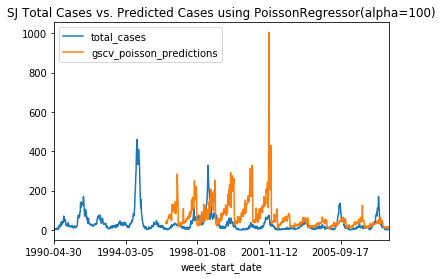

In [54]:
#SJ: graph best GSCV Poisson model

gscv_poisson_preds_sj = graph_gscv_preds(gscv_poisson_sj, full_pipeline, model, X_sj, y_train_sj, 'poisson')

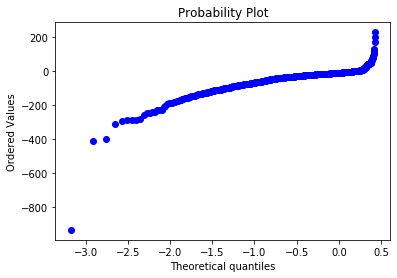

In [57]:
#qq-plot for Poisson Regression

import pylab 
import scipy.stats as stats

residuals_sj = gscv_poisson_preds_sj.total_cases - gscv_poisson_preds_sj.gscv_poisson_predictions
gscv_poisson_preds_sj['residuals'] = residuals_sj

stats.probplot(residuals_sj, dist="norm", plot=pylab)
pylab.show()

In summary, a Poisson regression model does not fit the data well (non-normal errors), likely because the variance of `total_cases` is much greater than its mean. While the model does seem to capture some of the cyclical nature of the data, it doesn't do so accurately.

#### Random Forest Regressor

In [58]:
#RF Regressor

rf_parameters = {'model__n_estimators': [2, 5, 10, 20], 'model__max_depth': [5, 10, 15, 20, None], 'model__min_samples_leaf': [1, 2, 5, 10], 'model__max_features': ['auto', 'sqrt', .333]}
model = RandomForestRegressor(criterion = 'mae', random_state = 0)

full_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  model)
])

gscv_rf_sj = GridSearchCV(estimator=full_pipeline, param_grid=rf_parameters, scoring = 'neg_mean_absolute_error', cv=tscv)
gscv_rf_sj.fit(X_sj, y_train_labels_sj)

print("Best parameter (CV score=%0.3f):" % gscv_rf_sj.best_score_)
print(gscv_rf_sj.best_params_)
print("all results:")
pd.DataFrame(gscv_rf_sj.cv_results_)

Best parameter (CV score=-20.618):
{'model__max_depth': 15, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 10, 'model__n_estimators': 10}
all results:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.069301,0.018407,0.012870,0.000929,5,auto,1,2,"{'model__max_depth': 5, 'model__max_features':...",-34.410256,-21.748397,-28.079327,6.330929,123
1,0.133918,0.062703,0.010760,0.000210,5,auto,1,5,"{'model__max_depth': 5, 'model__max_features':...",-29.466987,-22.858974,-26.162981,3.304006,100
2,0.235630,0.103106,0.010668,0.001638,5,auto,1,10,"{'model__max_depth': 5, 'model__max_features':...",-27.875160,-22.905929,-25.390545,2.484615,85
3,0.394837,0.156870,0.011290,0.001642,5,auto,1,20,"{'model__max_depth': 5, 'model__max_features':...",-29.064744,-20.394231,-24.729487,4.335256,73
4,0.056830,0.022920,0.010472,0.000499,5,auto,2,2,"{'model__max_depth': 5, 'model__max_features':...",-37.907051,-20.971154,-29.439103,8.467949,137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.228139,0.108039,0.014335,0.000805,None,0.333,5,20,"{'model__max_depth': None, 'model__max_feature...",-30.078205,-19.794712,-24.936458,5.141747,79
236,0.037742,0.012503,0.015633,0.001032,None,0.333,10,2,"{'model__max_depth': None, 'model__max_feature...",-41.126603,-19.976763,-30.551683,10.574920,153
237,0.063685,0.027521,0.011892,0.003110,None,0.333,10,5,"{'model__max_depth': None, 'model__max_feature...",-33.510577,-19.137179,-26.323878,7.186699,101
238,0.120559,0.050226,0.016611,0.000222,None,0.333,10,10,"{'model__max_depth': None, 'model__max_feature...",-25.482372,-17.527244,-21.504808,3.977564,29


In [59]:
#RF regression with lowest mean absolute error (SJ)

pd.DataFrame(gscv_rf_sj.cv_results_).loc[pd.DataFrame(gscv_rf_sj.cv_results_).rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
126,0.089763,0.034128,0.015017,0.000055,15,sqrt,10,10,"{'model__max_depth': 15, 'model__max_features'...",-23.335417,-17.900801,-20.618109,2.717308,1
174,0.078454,0.032478,0.014002,0.001956,20,sqrt,10,10,"{'model__max_depth': 20, 'model__max_features'...",-23.335417,-17.900801,-20.618109,2.717308,1
222,0.084165,0.034215,0.020274,0.000382,None,sqrt,10,10,"{'model__max_depth': None, 'model__max_feature...",-23.335417,-17.900801,-20.618109,2.717308,1


The best random forest fit using GridSearch cross validation on the SJ data achieved a much lower mean absolute error than the Poisson regressor. This may be due to the non-parametric nature of random forests as they do not have to conform to an underlying distribution. 

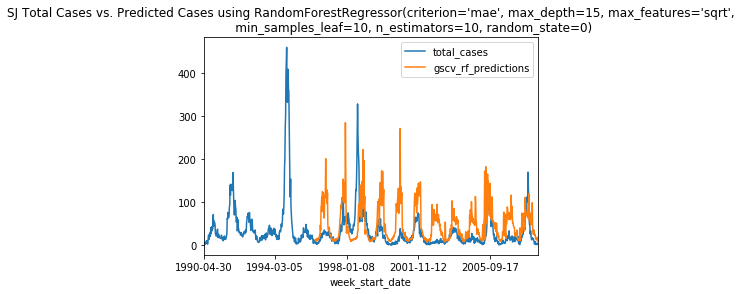

In [60]:
#Graph best GSCV RF model

gscv_rf_preds_sj = graph_gscv_preds(gscv_rf_sj, full_pipeline, model, X_sj, y_train_sj, 'rf')

The best random forest fit is similar to the Poisson regressor in its cyclical nature (although the random forest is much closer). Advanced feature engineering may be needed to capture these peaks.

#### XGBoost Regressor

In [97]:
#XGBoost Regressor

xgb_parameters = {'model__objective': ['reg:squarederror', 'count:poisson'], 'model__max_depth': [5, 10, 15, 20, None], 'model__min_child_weight': [1, 2, 5, 10], 'model__subsample': [1, .33, .67]}
model = XGBRegressor()

full_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  model)
])

gscv_xgb_sj = GridSearchCV(estimator=full_pipeline, param_grid=xgb_parameters, scoring = 'neg_mean_absolute_error', cv=tscv)
gscv_xgb_sj.fit(X_sj, y_train_labels_sj)

print("Best parameter (CV score=%0.3f):" % gscv_xgb_sj.best_score_)
print(gscv_xgb_sj.best_params_)
print("all results:")
pd.DataFrame(gscv_xgb_sj.cv_results_)

Best parameter (CV score=-21.058):
{'model__max_depth': 5, 'model__min_child_weight': 10, 'model__objective': 'reg:squarederror', 'model__subsample': 1}
all results:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__min_child_weight,param_model__objective,param_model__subsample,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.599981,0.036630,0.090993,0.035961,5,1,reg:squarederror,1,"{'model__max_depth': 5, 'model__min_child_weig...",-2.158754e+01,-2.184196e+01,-2.171475e+01,1.272121e-01,8
1,0.262174,0.058642,0.048136,0.015868,5,1,reg:squarederror,0.33,"{'model__max_depth': 5, 'model__min_child_weig...",-3.018045e+01,-2.683901e+01,-2.850973e+01,1.670722e+00,37
2,0.362457,0.070556,0.033524,0.000551,5,1,reg:squarederror,0.67,"{'model__max_depth': 5, 'model__min_child_weig...",-2.157325e+01,-2.205074e+01,-2.181200e+01,2.387448e-01,9
3,0.138512,0.029158,0.025658,0.000541,5,1,count:poisson,1,"{'model__max_depth': 5, 'model__min_child_weig...",-3.370195e+01,-1.207388e+07,-6.036955e+06,6.036921e+06,69
4,0.143147,0.041228,0.026871,0.003060,5,1,count:poisson,0.33,"{'model__max_depth': 5, 'model__min_child_weig...",-6.178848e+13,-5.529661e+13,-5.854255e+13,3.245937e+12,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.045383,0.006543,0.000000,0.000000,None,10,reg:squarederror,0.33,"{'model__max_depth': None, 'model__min_child_w...",NaN,NaN,NaN,NaN,99
116,0.044125,0.002402,0.000000,0.000000,None,10,reg:squarederror,0.67,"{'model__max_depth': None, 'model__min_child_w...",NaN,NaN,NaN,NaN,98
117,0.038055,0.009865,0.000000,0.000000,None,10,count:poisson,1,"{'model__max_depth': None, 'model__min_child_w...",NaN,NaN,NaN,NaN,106
118,0.040765,0.009495,0.000000,0.000000,None,10,count:poisson,0.33,"{'model__max_depth': None, 'model__min_child_w...",NaN,NaN,NaN,NaN,118


In [98]:
#XGB regressor with lowest mean absolute error 

pd.DataFrame(gscv_xgb_sj.cv_results_).loc[pd.DataFrame(gscv_xgb_sj.cv_results_).rank_test_score == 1]
# [['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'mean_test_score', 'rank_test_score']]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__min_child_weight,param_model__objective,param_model__subsample,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
18,0.304917,0.075597,0.028547,0.004002,5,10,reg:squarederror,1,"{'model__max_depth': 5, 'model__min_child_weig...",-21.536559,-20.579393,-21.057976,0.478583,1


[10:55:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:55:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


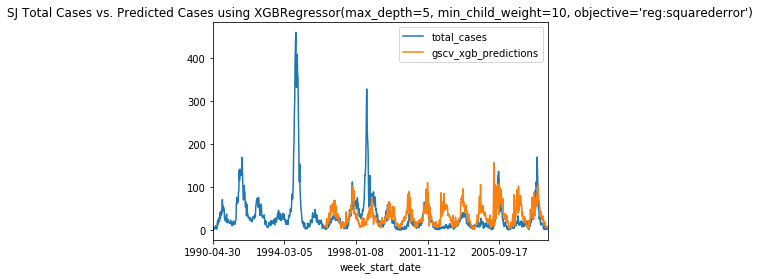

In [99]:
#Graph best GSCV XGB model

gscv_xgb_preds_sj = graph_gscv_preds(gscv_xgb_sj, full_pipeline, model, X_sj, y_train_sj, 'xgb')

The best XGBoost regressor trained on the dataset performed slightly worse than the best random forest and still much better than the best Poisson regressor. Unlike the random forest, it also captured many of the peaks.

#### HGB Regressor

In [67]:
#HGB Regressor

model = HistGradientBoostingRegressor(loss = 'poisson', random_state = 0)
hgb_parameters = {'model__learning_rate': [0.05, 0.1, 0.3], 'model__max_depth': [5, 10, 15], 'model__min_samples_leaf': [1, 5, 10], 'model__l2_regularization': [0, 0.5, 1, 5]}

full_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  model)
])

gscv_hgb_sj = GridSearchCV(estimator=full_pipeline, param_grid=hgb_parameters, scoring = 'neg_mean_absolute_error', cv=tscv)
gscv_hgb_sj.fit(X_sj, y_train_labels_sj)

print("Best parameter (CV score=%0.3f):" % gscv_hgb_sj.best_score_)
print(gscv_hgb_sj.best_params_)
print("all results:")
pd.DataFrame(gscv_hgb_sj.cv_results_)

Best parameter (CV score=-18.505):
{'model__l2_regularization': 1, 'model__learning_rate': 0.3, 'model__max_depth': 5, 'model__min_samples_leaf': 1}
all results:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__l2_regularization,param_model__learning_rate,param_model__max_depth,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.667028,0.021092,0.018738,0.001712,0,0.05,5,1,"{'model__l2_regularization': 0, 'model__learni...",-20.365759,-18.355693,-19.360726,1.005033,35
1,0.728705,0.173183,0.018473,0.000521,0,0.05,5,5,"{'model__l2_regularization': 0, 'model__learni...",-20.455380,-18.752035,-19.603707,0.851672,71
2,0.422872,0.056252,0.017957,0.000992,0,0.05,5,10,"{'model__l2_regularization': 0, 'model__learni...",-20.391046,-18.784446,-19.587746,0.803300,68
3,1.078413,0.024443,0.018949,0.000997,0,0.05,10,1,"{'model__l2_regularization': 0, 'model__learni...",-20.218889,-18.075433,-19.147161,1.071728,22
4,0.911677,0.071777,0.017569,0.000614,0,0.05,10,5,"{'model__l2_regularization': 0, 'model__learni...",-20.510412,-18.544084,-19.527248,0.983164,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,1.048823,0.080769,0.025432,0.000499,5,0.3,10,5,"{'model__l2_regularization': 5, 'model__learni...",-20.897887,-18.211604,-19.554746,1.343141,61
104,0.788590,0.116237,0.024434,0.001496,5,0.3,10,10,"{'model__l2_regularization': 5, 'model__learni...",-20.837483,-18.056903,-19.447193,1.390290,46
105,1.432813,0.076016,0.024934,0.000997,5,0.3,15,1,"{'model__l2_regularization': 5, 'model__learni...",-20.914008,-18.410231,-19.662119,1.251889,80
106,1.020437,0.059456,0.023609,0.001324,5,0.3,15,5,"{'model__l2_regularization': 5, 'model__learni...",-21.020894,-17.585093,-19.302994,1.717900,30


In [68]:
#HGB regressor with lowest mean absolute error

pd.DataFrame(gscv_hgb_sj.cv_results_).loc[pd.DataFrame(gscv_hgb_sj.cv_results_).rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__l2_regularization,param_model__learning_rate,param_model__max_depth,param_model__min_samples_leaf,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
72,0.782436,0.136046,0.024581,0.001642,1,0.3,5,1,"{'model__l2_regularization': 1, 'model__learni...",-20.770244,-16.239577,-18.504911,2.265334,1


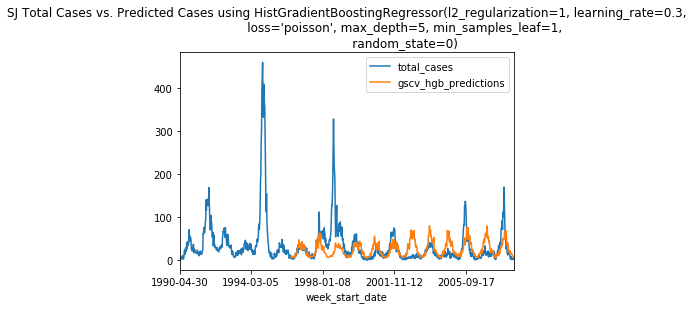

In [69]:
#Graph best GSCV HGB model

gscv_hgb_preds_sj = graph_gscv_preds(gscv_hgb_sj, full_pipeline, model, X_sj, y_train_sj, 'hgb')

#### KNN Regressor

In [70]:
#KNN Regressor

model = KNeighborsRegressor()
knn_parameters = {'model__n_neighbors': [5,10,30,50,70,90], 'model__weights': ['distance', 'uniform']}

full_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor_pipeline),
    ('model',  model)
])

gscv_knn_sj = GridSearchCV(estimator=full_pipeline, param_grid=knn_parameters, scoring = 'neg_mean_absolute_error', cv=tscv)
gscv_knn_sj.fit(X_sj, y_train_labels_sj)

print("Best parameter (CV score=%0.3f):" % gscv_knn_sj.best_score_)
print(gscv_knn_sj.best_params_)
print("all results:")
pd.DataFrame(gscv_knn_sj.cv_results_)

Best parameter (CV score=-31.121):
{'model__n_neighbors': 90, 'model__weights': 'distance'}
all results:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,param_model__weights,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.023801,0.002183,0.021186,0.003232,5,distance,"{'model__n_neighbors': 5, 'model__weights': 'd...",-38.664202,-24.451409,-31.557805,7.106396,5
1,0.015587,0.002622,0.018087,0.002861,5,uniform,"{'model__n_neighbors': 5, 'model__weights': 'u...",-38.759615,-24.531410,-31.645513,7.114103,6
2,0.015960,0.002992,0.018462,0.003486,10,distance,"{'model__n_neighbors': 10, 'model__weights': '...",-38.135033,-24.308214,-31.221623,6.913410,3
3,0.010383,0.000557,0.023026,0.007033,10,uniform,"{'model__n_neighbors': 10, 'model__weights': '...",-38.325962,-24.427564,-31.376763,6.949199,4
4,0.012578,0.002518,0.022357,0.002255,30,distance,"{'model__n_neighbors': 30, 'model__weights': '...",-39.211444,-24.583658,-31.897551,7.313893,9
5,0.016097,0.004012,0.018880,0.000823,30,uniform,"{'model__n_neighbors': 30, 'model__weights': '...",-39.492949,-24.710256,-32.101603,7.391346,10
6,0.017509,0.002307,0.017536,0.002351,50,distance,"{'model__n_neighbors': 50, 'model__weights': '...",-39.782432,-24.856494,-32.319463,7.462969,11
7,0.017055,0.006294,0.019482,0.003676,50,uniform,"{'model__n_neighbors': 50, 'model__weights': '...",-40.038077,-24.959615,-32.498846,7.539231,12
8,0.011923,0.001000,0.023591,0.005143,70,distance,"{'model__n_neighbors': 70, 'model__weights': '...",-38.245437,-25.149834,-31.697636,6.547801,7
9,0.016160,0.003325,0.018727,0.003066,70,uniform,"{'model__n_neighbors': 70, 'model__weights': '...",-38.272253,-25.252427,-31.762340,6.509913,8


In [71]:
#KNN regressor with lowest mean absolute error

pd.DataFrame(gscv_knn_sj.cv_results_).loc[pd.DataFrame(gscv_knn_sj.cv_results_).rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_neighbors,param_model__weights,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
10,0.014121,0.001062,0.019892,0.004825,90,distance,"{'model__n_neighbors': 90, 'model__weights': '...",-36.838387,-25.402996,-31.120691,5.717695,1


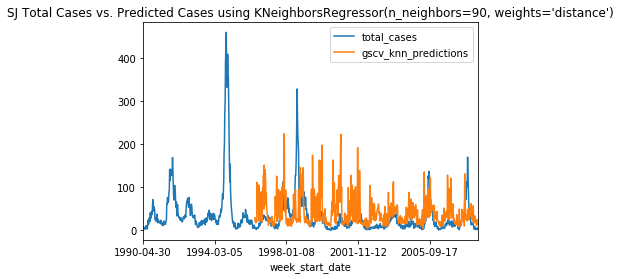

In [72]:
#Graph best GSCV KNN model

gscv_knn_preds_sj = graph_gscv_preds(gscv_knn_sj, full_pipeline, model, X_sj, y_train_sj, 'knn')

# Advanced Feature Engineering

### Preprocessing and Feature Engineering

In [73]:
#Creating function to reflect the cyclical nature of week and month

def cycle(row):
    row.weekofyear = abs(np.sin(row.weekofyear * np.pi / 52))
    row.month = abs(np.sin(row.month * np.pi / 12))
    return row

In [74]:
#Implementing cycle on X_train_sj_feat_eng and X_train_iq_feat_eng data sets

X_train_sj_feat_eng_adv = X_train_sj_feat_eng.apply(cycle, axis = 'columns')

The cycle feature does not require being wrapped in a pipeline as it is independent of the data itself and therefore can not result in data leakage.

In [75]:
#Dropping one of perfectly correlated variables (precipitation_amt_mm and reanalysis_sat_precip_amt_mm)

X_train_sj_feat_eng_adv = X_train_sj_feat_eng_adv.drop('precipitation_amt_mm', axis = 1)

In [76]:
#Custom Transformer for NDVI variables

class NDVI_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, city): 
        self.city = city
    
    #Return self, nothing else to do here
    def fit(self, X, y = None):
        return self 
    
    def transform(self, X, y = None):
        #because the original X has been transformed (scaled and imputed), it comes in as an array (and not a df)
        ndvi_north = (X[:, 0]**2 + X[:, 1]**2) / 2
        ndvi_south = (X[:, 2]**2 + X[:, 3]**2) / 2
        ndvi_north = ndvi_north.reshape((X.shape[0], 1))
        ndvi_south = ndvi_south.reshape((X.shape[0], 1))
        X = np.append(X, ndvi_north, axis = 1)
        X = np.append(X, ndvi_south, axis = 1)

        #drop the first four columns, which are the original NDVI columns as they are the first four columns passed through the ColumnTransformer
        return X[:, 4:]

In [77]:
#Advanced preprocessing pipeline

std_scaler = StandardScaler()
knn_imputer = KNNImputer(weights = 'distance')

ndvi_cols = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']
X_adv_sj = X_train_sj_feat_eng_adv.select_dtypes(include=['float64', 'int64'])
remaining_cols = [col for col in X_adv_sj.columns if col not in ndvi_cols]

sj_ndvi_transf = NDVI_Transformer(city = 'sj')

sj_ndvi_pipeline = Pipeline(steps = [
    ('scale', std_scaler),
    ('impute', knn_imputer), 
    ('ndvi_feat_eng', sj_ndvi_transf)
])

remaining_cols_pipeline = Pipeline(steps = [
    ('scale', std_scaler),
    ('impute', knn_imputer)
])

sj_preprocessor_pipeline = ColumnTransformer(transformers = [
    ('sj_ndvi_transf', sj_ndvi_pipeline, ndvi_cols),
    ('sj_remain_transf', remaining_cols_pipeline, [col for col in X_adv_sj.columns if col not in ndvi_cols])],
    remainder = 'passthrough')

sj_preprocessor_pipeline.fit_transform(X_adv_sj)[0]

array([ 0.259336  ,  0.08809219, -1.69445772,  0.80812223, -1.28729706,
       -1.25951191, -1.71769495, -1.27066773, -1.08332173,  0.04309543,
       -1.53570886, -0.51704213, -1.62783035,  0.22522843, -1.10529281,
        0.17069943, -1.28640851, -1.72746785, -0.36797916,  1.68112446,
        0.7385682 ])

Random forests and boosting are invariant to scaling, but distance is used to fit support vector regression and k-nearest neighbors regression. Therefore, we scaled the non-NDVI columns to help improve performance of those models.

In [78]:
#Create function that divides dataset into folds using TimeSeriesSplit
##tscv_train_dict, tscv_val_dict are dictionaries

def create_folds(X):
    tscv_train_dict = {}
    tscv_val_dict = {}
    fold_num = 0
    
    if X.equals(X_adv_sj):
        ts = tscv
    else:
        print('error: wrong dataset')
    
    for train_index, val_index in ts.split(X):
        fold_num += 1
        tscv_train_dict[fold_num] = X.iloc[train_index]
        tscv_val_dict[fold_num] = X.iloc[val_index]
    
    return tscv_train_dict, tscv_val_dict

In [79]:
#Create function that preprocesses the training and validation sets using the preprocessing pipeline
##train_fold and val_fold are dataframes

def preprocess(X_train, X_val, pipeline, cols):
    train_fold = pd.DataFrame(pipeline.fit_transform(X_train), index = X_train.index, columns = cols)
    val_fold = pd.DataFrame(pipeline.transform(X_val), index = X_val.index, columns = cols)
    
    return train_fold, val_fold

In [80]:
#Create function that creates a rolling window for the columns specified
##X_train_rolling, X_val_rolling are dataframes with new 'rolling' columns

def rolling_inputs(X_train, X_val, cols, window):
    #by combining the train and validation sets, we are able to retrieve train data to create the first couple of entries in the
    #rolling columns of the valid set. This does not lead to leakage as the information flows from train to validation, not vice versa
    full_fold_df = pd.concat((X_train, X_val))
    for col in cols:
        rolling_col_name = '{}_rolling_{}'.format(col, window)
        full_fold_df[rolling_col_name] = full_fold_df[col].shift(window, axis = 0).fillna(0)
    X_train_rolling = full_fold_df.loc[X_train.index]
    X_val_rolling = full_fold_df.loc[X_val.index]
    return X_train_rolling, X_val_rolling

It is likely that a mosquito carrying dengue fever can spread the disease for several weeks after it first contracts the virus. Therefore, many of the cases in a given week could be a result of weather patterns occurring several weeks before. As a result, we will create rolling features that take into account previous weeks to see if these can lead to better predictions. 

In [81]:
#Create functions that uses previous week's `total_cases` (real or predicted) as an input for the current week

def prev_total_cases(X_train, X_val, y):
    X_train['previous_week_total_cases'] = y.loc[X_train.index].shift(periods=1, fill_value=0)
    
    #creating the same column, `previous_week_total_cases`, in X_val and changing the earliest week to have the last week's value, 
    #which comes from X_train. All other values are converted to -1, to indicate an impossible prediction given these values are non-negative counts
    X_val['previous_week_total_cases'] = -1
    X_val.previous_week_total_cases.iloc[0] = y.loc[X_train.index].iloc[-1]
    return X_train, X_val

def last_prediction_as_input(X_val, idx, pred = None):
    #take the most recent preciction (which will start with the earliest week in X_val) 
    #and add it to the `previous_week_total_cases` of the next week
    X_val.previous_week_total_cases.loc[idx+1] = pred
    return X_val
    

Additionally, given the contagious nature of the virus, previous weeks' case counts could be an important predictor for the current week's. We've added the last week's `total_cases` as an input to predict the current week's `total_cases` in the training folds. In the validation folds, the first week is taken from the last week of the training fold (since the time series split orders the folds chronologically) and every input following is the predicted `total_cases`.

In [82]:
#Create function that makes predictions sequentially and uses last_prediction_as_input function to generate input data for current week

def predict_seq(X_val, model):
    pred_list = []
    for idx in X_val.index:
        pred = model.predict(X_val.loc[idx].to_frame().transpose())
        pred_list.append(float(pred))
        if idx != X_val.index.max():
            X_val = last_prediction_as_input(X_val, idx, pred)
    return pred_list, X_val

Cross-validation offered through scikit-learn can not be used given that we need to combine the folds in order to add these extra inputs. This will not result in data leakage as no information from the validation fold will be used when training the training folds.

In [83]:
#Create function that replicates (the most important columns from) a row of the GridSearchCV dataframe

def gscv_df(mae_dict, params):
    cols = []
    data = []
    for fold_n, fold_score in mae_dict.items():
        #creating lists of the split scores for each fold and the corresponding column names
        cols.append('split{}_score'.format(fold_n))
        data.append(fold_score)
    
    #adding the mean score to the list of scores and column names
    cols.append('mean_score')
    mean_score = np.array(data).mean()
    data.append(mean_score)
    data = np.array(data).reshape(1,-1)
    
    #creating df with cv scores for each fold and the mean score of all folds
    df = pd.DataFrame(data = data, columns = cols)
    
    #adding the model's parameters to the df
    df['model_params'] = params

    #rearranging the columns so that the parameters are first
    df_cols = df.columns.tolist()
    df_cols = df_cols[-1:] + df_cols[:-1]
    df = df[df_cols]    
    return df

In [84]:
#Creating function for preprocessing, adding additional rolling features, and storing cv folds into dictionaries
##Returns dictionaries of train and validation folds

def prep_for_model(X, window_size):
    
    if X.equals(X_adv_sj):
        cols_transf = ['ndvi_north', 'ndvi_south'] + sj_preprocessor_pipeline.transformers_[1][2]
        weather_cols = [col for col in cols_transf if col not in ['total_cases', 'year', 'weekofyear', 'day', 'month', 'ndvi_north', 'ndvi_south']]
        rolling_cols = [col for col in weather_cols if col in abs(df_train_sj.corr()['total_cases']).sort_values(ascending = False).head(10)]
        preprocessor_pipeline = sj_preprocessor_pipeline
        y_train_labels = y_train_labels_sj
        ts = tscv
    elif X.equals(X_adv_iq):
        cols_transf = ['ndvi_all'] + iq_preprocessor_pipeline.transformers_[1][2]
        weather_cols = [col for col in cols_transf if col not in ['total_cases', 'year', 'weekofyear', 'day', 'month', 'ndvi_all']]
        rolling_cols = [col for col in weather_cols if col in abs(df_train_iq.corr()['total_cases']).sort_values(ascending = False).head(10)]
        preprocessor_pipeline = iq_preprocessor_pipeline
        y_train_labels = y_train_labels_iq 
        ts = tscv2

    #creating folds on X
    tscv_train_dict, tscv_val_dict = create_folds(X)

    #preprocessing the folds and replacing the raw data with the processed data in the dictionaries
    for fold_n in [x+1 for x in list(range(ts.n_splits))]:
        train_fold, val_fold = preprocess(tscv_train_dict[fold_n], tscv_val_dict[fold_n], preprocessor_pipeline, cols_transf)
        tscv_train_dict[fold_n] = train_fold
        tscv_val_dict[fold_n] = val_fold
            
        #adding rolling inputs to folds and storing in dictionaries
        train_fold_rolling, val_fold_rolling = rolling_inputs(train_fold, val_fold, rolling_cols, window_size)
        tscv_train_dict[fold_n] = train_fold_rolling
        tscv_val_dict[fold_n] = val_fold_rolling

        #adding previous_week_total_cases as an input to folds and storing in dictionaries
        train_fold_pw, val_fold_pw = prev_total_cases(tscv_train_dict[fold_n], tscv_val_dict[fold_n], y_train_labels)
        tscv_train_dict[fold_n] = train_fold_pw
        tscv_val_dict[fold_n] = val_fold_pw
    
    return tscv_train_dict, tscv_val_dict

In [86]:
#Create function that performs cross-validation on the advanced feature engineering
##Returns df with results of cross-validation and predictions of each model

def cv_adv(X, window_size, model, parameters):
    
    #Create dictionaries of preprocessed and feature-engineered folds for cross-validation
    tscv_train_dict, tscv_val_dict = prep_for_model(X, window_size)
    
    param_n = 0
    mae_dict = {}
    pred_dict = {}
    
    y = y_train_labels_sj
    ts = tscv

    #finding all combinations of parameters for the model to be used in cv
    keys = parameters.keys()
    values = [parameters[key] for key in keys]
    param_combos = [dict(zip(keys, combination)) for combination in itertools.product(*values)]

    for param in param_combos:
        model = model.set_params(**param)

        param_n += 1
        pred_dict[param_n] = {}

        for fold_n in [x+1 for x in list(range(ts.n_splits))]:
            #retrieving the preprocessed and feature-engineered train and validation folds
            train = tscv_train_dict[fold_n]
            val = tscv_val_dict[fold_n]

            #defining indeces of the current train and validation fold
            train_index = train.index
            val_index = val.index

            #defining y_train and y_val that correspond to the train and validation sets of the current fold
            y_train = y.loc[train_index]
            y_val = y.loc[val_index]

            #training the model on the training part of the fold
            model.fit(train, y_train)

            #making predictions on validation set, one at a time, and adding past prediction as input to current week
            pred_list, _ = predict_seq(val, model)
            pred_dict[param_n][fold_n] = pred_list

            #calculating mae and storing in a dictionary (rewrites over mae_dict of past parameters)
            mae_dict[fold_n] = mean_absolute_error(pred_list, y_val)

        #combine all dataframes of different parameters into one
        if param_n == 1:
            cv_df = gscv_df(mae_dict, str(param))
        else:
            cv_df = cv_df.append(gscv_df(mae_dict, str(param)), ignore_index = True)

    #add rank column based on lowest MAE score        
    cv_df['rank'] = cv_df.mean_score.rank(ascending = True, method = 'first')
    return cv_df, pred_dict

In [87]:
#Function that adds predictions of best model (model with parameters that had the lowest MAE score during gridsearch cv) to y_train

def add_preds_to_y(cv_df, pred_dict, model, X, y, model_name):
    val_preds = []
    val_indeces = []
    
    if X_adv_sj.equals(X):
        ts = tscv
    else:
        print('error: wrong dataset')
    
    for train_index, val_index in ts.split(X):
        val_indeces += list(val_index)
     
    #finding parameters of model that performed best during cv
    #adding 1 to align param_n with cv_df as the dictionary keys for param_n start at 1 whereas the cv_df index starts at 0
    best_param = cv_df.loc[cv_df['rank'] == 1].model_params.index[0] + 1
    
    #retrieving predictions from model with best_param
    for key in pred_dict[best_param].keys():
        val_preds += pred_dict[best_param][key]

    
    city = 'SJ'
    gscv_adv_preds = pd.DataFrame(val_preds, index = val_indeces, columns = ['gscv_adv_{}_predictions'.format(model_name)])
    
    return gscv_adv_preds, city

In [88]:
#Function that graphs `total_cases` and the predictions found during cross validation of the best model 

def graph_gscv_adv_preds(cv_df, pred_dict, model, X, y, model_name):
    y_labels = y.total_cases
    gscv_adv_preds, city = add_preds_to_y(cv_df, pred_dict, model, X, y, model_name)
    gscv_adv_preds = y.join(gscv_adv_preds, how = 'left')
    gscv_adv_preds[['week_start_date','total_cases', 'gscv_adv_{}_predictions'.format(model_name)]].set_index('week_start_date').plot()
    plt.title('{} Total Cases vs. Predicted Cases using {}'.format(city, model.set_params(**eval(cv_df.loc[cv_df['rank'] == 1].model_params.values[0]))))
    return gscv_adv_preds

### Modeling

#### XGBoost Regressor

Before modeling, we'll use the XGBoost regressor to determine the optimal window size for our rolling variables. 

In [100]:
#Running CV on XGBoost regressors with different window sizes

xgb_model = XGBRegressor(objective = 'reg:squarederror')
xgb_parameters = {'max_depth': [5, 10, 15, 20], 'min_child_weight': [1, 2, 5, 10], 'subsample': [1, 1/3, 2/3]}

window_size_list = [0,1,2,3,4,5,6,7]

for w in window_size_list:
    print(w)
    cv_df_xgb, pred_dict_xgb = cv_adv(X_adv_sj, w, xgb_model, xgb_parameters)
    if w == window_size_list[0]:
        score_by_window_df = cv_df_xgb.loc[cv_df_xgb['rank'] == 1]
    else:
        score_by_window_df = score_by_window_df.append(cv_df_xgb.loc[cv_df_xgb['rank'] == 1], ignore_index = True)

score_by_window_df['window_size'] = window_size_list
score_by_window_df['w_rank'] = score_by_window_df.mean_score.rank(ascending = True, method = 'first')

score_by_window_df

0
1
2
3
4
5
6
7


,model_params,split1_score,split2_score,mean_score,rank,window_size,w_rank
0,"{'max_depth': 20, 'min_child_weight': 1, 'subs...",20.728549,13.702859,17.215704,1.0,0,4.0
1,"{'max_depth': 5, 'min_child_weight': 5, 'subsa...",20.133906,14.683333,17.408620,1.0,1,6.0
2,"{'max_depth': 10, 'min_child_weight': 1, 'subs...",19.320963,14.708080,17.014522,1.0,2,2.0
3,"{'max_depth': 10, 'min_child_weight': 1, 'subs...",19.339172,15.772979,17.556075,1.0,3,8.0
4,"{'max_depth': 10, 'min_child_weight': 1, 'subs...",19.389806,15.151583,17.270694,1.0,4,5.0
5,"{'max_depth': 20, 'min_child_weight': 1, 'subs...",16.691536,16.097089,16.394313,1.0,5,1.0
6,"{'max_depth': 15, 'min_child_weight': 1, 'subs...",20.330986,13.925100,17.128043,1.0,6,3.0
7,"{'max_depth': 10, 'min_child_weight': 2, 'subs...",18.412150,16.470104,17.441127,1.0,7,7.0


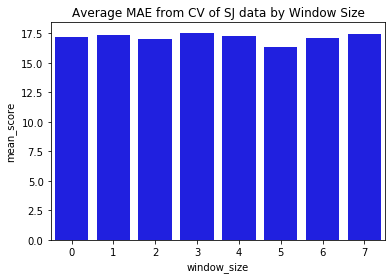

In [101]:
#Graphing the average MAE from CV by window size (SJ)

y = score_by_window_df.mean_score
x = score_by_window_df.window_size
sns.barplot(x = x, y = y, color='b')
plt.title('Average MAE from CV of SJ data by Window Size')
plt.show()

A window size of 5 weeks results in the lowest mean cross-validated score for the best XGBoost model. This, in combination with domain knowledge that the type of mosquitoes that carry the virus have a lifespan between two and four weeks and that the time from infection to symptoms is about 4 to 7 days, leads us to believe that a window size of 5 weeks is reasonable. We could add window size as a hyperparameter to tune during cross validation but the window size is more of a reflection on dengue fever than the model's particular characteristics. As a result, we can feel confident that 5 weeks is most likely appropriate across all models. 

In [102]:
#Finding the best XGBoost model via cross validation

xgb_model = XGBRegressor(objective = 'reg:squarederror')
xgb_parameters = {'max_depth': [5, 10, 15, 20], 'min_child_weight': [1, 2, 5, 10], 'subsample': [1, 1/3, 2/3]}

cv_df_xgb_sj, pred_dict_xgb_sj = cv_adv(X_adv_sj, 5, xgb_model, xgb_parameters)
cv_df_xgb_sj

,model_params,split1_score,split2_score,mean_score,rank
0,"{'max_depth': 5, 'min_child_weight': 1, 'subsa...",18.208885,32.188066,25.198476,34.0
1,"{'max_depth': 5, 'min_child_weight': 1, 'subsa...",18.037480,19.891092,18.964286,10.0
2,"{'max_depth': 5, 'min_child_weight': 1, 'subsa...",18.575986,20.698942,19.637464,12.0
3,"{'max_depth': 5, 'min_child_weight': 2, 'subsa...",18.410447,29.689447,24.049947,29.0
4,"{'max_depth': 5, 'min_child_weight': 2, 'subsa...",19.798651,29.139579,24.469115,31.0
...,...,...,...,...,...
43,"{'max_depth': 20, 'min_child_weight': 5, 'subs...",150.148312,26.786831,88.467572,44.0
44,"{'max_depth': 20, 'min_child_weight': 5, 'subs...",18.770329,23.188307,20.979318,21.0
45,"{'max_depth': 20, 'min_child_weight': 10, 'sub...",17.534493,29.466900,23.500696,28.0
46,"{'max_depth': 20, 'min_child_weight': 10, 'sub...",165.712582,33.540060,99.626321,48.0


In [104]:
#XGB regressor with lowest mean absolute error

cv_df_xgb_sj.loc[cv_df_xgb_sj['rank'] == 1]

,model_params,split1_score,split2_score,mean_score,rank
37,"{'max_depth': 20, 'min_child_weight': 1, 'subs...",16.691536,16.097089,16.394313,1.0


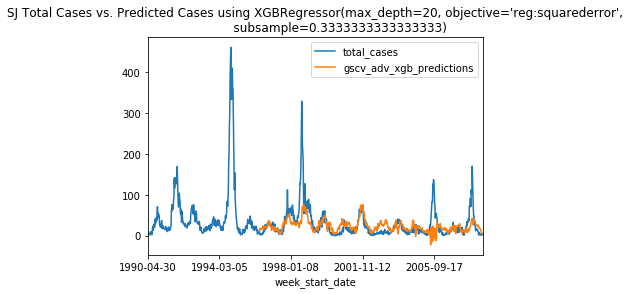

In [93]:
#Graphing the predictions generated during CV of the best XGBoost model (model with parameters that had the lowest MAE score during gridsearch cv)

gscv_adv_preds_xgb_sj = graph_gscv_adv_preds(cv_df_xgb_sj, pred_dict_xgb_sj, xgb_model, X_adv_sj, y_train_sj, 'xgb')

#### Random Forest Regressor

In [105]:
#Finding the best RF model via cross validation

rf_model = RandomForestRegressor(criterion = 'mae', random_state = 0)
rf_parameters = {'n_estimators': [2, 5, 10, 20], 'max_depth': [5, 10, 15, 20, None], 'min_samples_leaf': [1, 2, 5, 10], 'max_features': ['auto', 'sqrt', 1/3]}

cv_df_rf_sj, pred_dict_rf_sj = cv_adv(X_adv_sj, 5, rf_model, rf_parameters)
cv_df_rf_sj

,model_params,split1_score,split2_score,mean_score,rank
0,"{'n_estimators': 2, 'max_depth': 5, 'min_sampl...",22.465545,15.366987,18.916266,7.0
1,"{'n_estimators': 2, 'max_depth': 5, 'min_sampl...",27.400641,22.330929,24.865785,128.0
2,"{'n_estimators': 2, 'max_depth': 5, 'min_sampl...",27.630609,22.232372,24.931490,129.0
3,"{'n_estimators': 2, 'max_depth': 5, 'min_sampl...",22.427083,22.251603,22.339343,74.0
4,"{'n_estimators': 2, 'max_depth': 5, 'min_sampl...",26.110577,22.801282,24.455929,124.0
...,...,...,...,...,...
235,"{'n_estimators': 20, 'max_depth': None, 'min_s...",22.213862,19.765865,20.989864,34.0
236,"{'n_estimators': 20, 'max_depth': None, 'min_s...",22.295913,21.840545,22.068229,66.0
237,"{'n_estimators': 20, 'max_depth': None, 'min_s...",115.082131,15.292308,65.187220,234.0
238,"{'n_estimators': 20, 'max_depth': None, 'min_s...",24.842949,20.125481,22.484215,79.0


In [106]:
#RF regressor with lowest mean absolute error

cv_df_rf_sj.loc[cv_df_rf_sj['rank'] == 1]

,model_params,split1_score,split2_score,mean_score,rank
27,"{'n_estimators': 2, 'max_depth': 15, 'min_samp...",19.096154,15.255609,17.175881,1.0


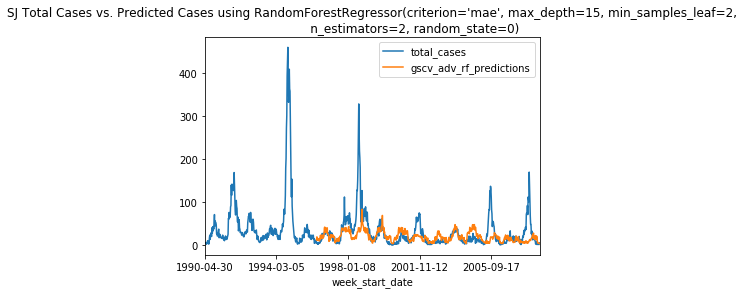

In [107]:
#Graphing the predictions generated during CV of the best RF model

gscv_adv_preds_rf_sj = graph_gscv_adv_preds(cv_df_rf_sj, pred_dict_rf_sj, rf_model, X_adv_sj, y_train_sj, 'rf')

#### Histogram Gradient Boosting

In [108]:
#Finding the best HGBoost model via cross validation

hgb_model = HistGradientBoostingRegressor(loss = 'poisson', random_state = 0)
hgb_parameters = {'learning_rate': [0.05, 0.1, 0.3], 'max_depth': [5, 10, 15], 'min_samples_leaf': [1, 5, 10], 'l2_regularization': [0, 0.5, 1, 5]}

cv_df_hgb_sj, pred_dict_hgb_sj = cv_adv(X_adv_sj, 5, hgb_model, hgb_parameters)
cv_df_hgb_sj

,model_params,split1_score,split2_score,mean_score,rank
0,"{'learning_rate': 0.05, 'max_depth': 5, 'min_s...",19.243017,25.172928,22.207972,76.0
1,"{'learning_rate': 0.05, 'max_depth': 5, 'min_s...",20.004146,18.052443,19.028294,30.0
2,"{'learning_rate': 0.05, 'max_depth': 5, 'min_s...",19.807011,21.713459,20.760235,57.0
3,"{'learning_rate': 0.05, 'max_depth': 5, 'min_s...",19.934777,26.068930,23.001853,85.0
4,"{'learning_rate': 0.05, 'max_depth': 5, 'min_s...",19.822060,26.792046,23.307053,87.0
...,...,...,...,...,...
103,"{'learning_rate': 0.3, 'max_depth': 15, 'min_s...",19.167570,13.337350,16.252460,1.0
104,"{'learning_rate': 0.3, 'max_depth': 15, 'min_s...",19.263905,20.148459,19.706182,44.0
105,"{'learning_rate': 0.3, 'max_depth': 15, 'min_s...",19.999549,23.071397,21.535473,68.0
106,"{'learning_rate': 0.3, 'max_depth': 15, 'min_s...",20.249152,22.390493,21.319823,66.0


In [109]:
#HGBoost regressor with lowest mean absolute error

pd.set_option('display.max_colwidth', 1000)
cv_df_hgb_sj.loc[cv_df_hgb_sj['rank'] == 1]
# cv_df_hgb_sj.loc[cv_df_hgb_sj.split4_score < 17]

,model_params,split1_score,split2_score,mean_score,rank
103,"{'learning_rate': 0.3, 'max_depth': 15, 'min_samples_leaf': 5, 'l2_regularization': 5}",19.16757,13.33735,16.25246,1.0


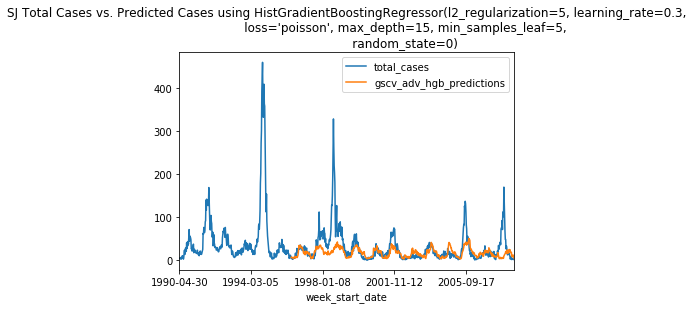

In [110]:
#Graphing the predictions generated during CV of the best HistGradBoosting model (model with parameters that had the lowest MAE score during gridsearch cv)

gscv_adv_preds_hgb_sj = graph_gscv_adv_preds(cv_df_hgb_sj, pred_dict_hgb_sj, hgb_model, X_adv_sj, y_train_sj, 'hgb')

#### KNN Regression

In [111]:
#Finding the best KNN model via cross validation

knn_model = KNeighborsRegressor()
knn_parameters = {'n_neighbors': [5,10,30,50,70,90], 'weights': ['distance', 'uniform']}

cv_df_knn_sj, pred_dict_knn_sj = cv_adv(X_adv_sj, 5, knn_model, knn_parameters)
cv_df_knn_sj

,model_params,split1_score,split2_score,mean_score,rank
0,"{'n_neighbors': 5, 'weights': 'distance'}",20.672699,18.033834,19.353266,11.0
1,"{'n_neighbors': 5, 'weights': 'uniform'}",21.265385,32.166026,26.715705,12.0
2,"{'n_neighbors': 10, 'weights': 'distance'}",22.134965,15.105479,18.620222,9.0
3,"{'n_neighbors': 10, 'weights': 'uniform'}",21.297756,14.984615,18.141186,6.0
4,"{'n_neighbors': 30, 'weights': 'distance'}",19.438337,15.041405,17.239871,1.0
5,"{'n_neighbors': 30, 'weights': 'uniform'}",19.292949,15.297115,17.295032,2.0
6,"{'n_neighbors': 50, 'weights': 'distance'}",19.637353,15.370226,17.503790,3.0
7,"{'n_neighbors': 50, 'weights': 'uniform'}",19.840064,15.515769,17.677917,4.0
8,"{'n_neighbors': 70, 'weights': 'distance'}",20.414679,15.853250,18.133965,5.0
9,"{'n_neighbors': 70, 'weights': 'uniform'}",20.720925,16.084799,18.402862,7.0


In [2395]:
#KNN regressor with lowest mean absolute error

cv_df_knn_sj.loc[cv_df_knn_sj['rank'] == 1]

,model_params,split1_score,split2_score,mean_score,rank
4,"{'n_neighbors': 30, 'weights': 'distance'}",19.438337,15.041405,17.239871,1.0


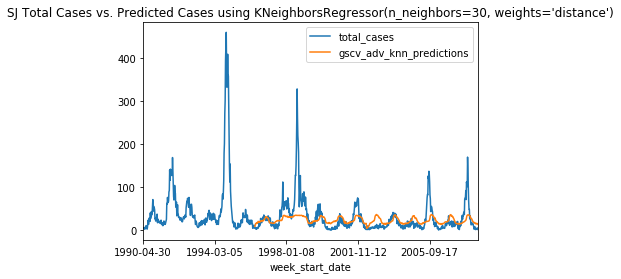

In [116]:
#Graphing the predictions generated during CV of the best KNN model (model with parameters that had the lowest MAE score during gridsearch cv)

gscv_adv_preds_knn_sj = graph_gscv_adv_preds(cv_df_knn_sj, pred_dict_knn_sj, knn_model, X_adv_sj, y_train_sj, 'knn')

### Comparing Models

Text(0.5, 1.0, 'Average MAE of Models Tuned during Cross Validation')

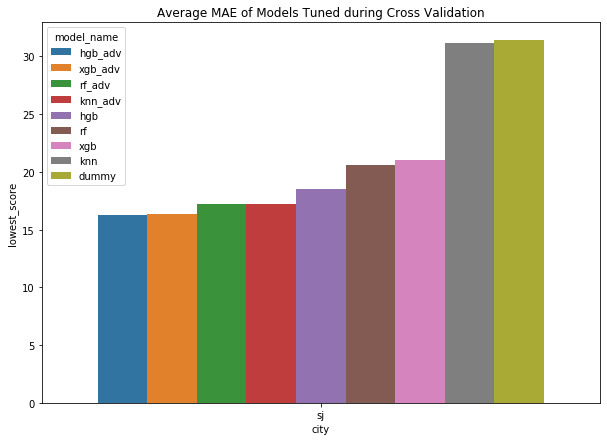

In [113]:
#Graphing mean CV scores to show best model in each city

best_model_scores = {'xgb_adv_sj':cv_df_xgb_sj, 'rf_adv_sj':cv_df_rf_sj, 'hgb_adv_sj':cv_df_hgb_sj, 'knn_adv_sj':cv_df_knn_sj, 
                     'rf_sj':pd.DataFrame(gscv_rf_sj.cv_results_), 'xgb_sj':pd.DataFrame(gscv_xgb_sj.cv_results_), 
                     'knn_sj':pd.DataFrame(gscv_knn_sj.cv_results_), 'hgb_sj':pd.DataFrame(gscv_hgb_sj.cv_results_)}

city_list = []
mn_list = []
ls = []

ls.append(abs(cv_dummy_sj.mean()))

city_list.append('sj')

mn_list.append('dummy')

df = pd.DataFrame()

for k, df_mae in best_model_scores.items():
    city = k.split('_')[-1]
    model_name = '_'.join(k.split('_')[:-1])
    mn_list.append(model_name)
    city_list.append(city)
    
    if len(k.split('_')) == 3:  #for models with advanced preprocessing (adv)
        ls.append(df_mae.loc[df_mae['rank'] == 1].mean_score.values[0])
    else:
        ls.append(abs(df_mae.loc[df_mae['rank_test_score'] == 1].mean_test_score.values[0]))

df['city'] = city_list
df['lowest_score'] = ls
df['model_name'] = mn_list
df.sort_values(by=['lowest_score'], ascending = True, inplace=True)

fig_dims = (10, 7)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x = 'city', y = 'lowest_score', hue = 'model_name', ax = ax, data = df)
# sns.barplot(x = 'model_name', y = 'lowest_score', ax = ax, data = df.loc[df.city == 'iq'])
plt.title('Average MAE of Models Tuned during Cross Validation')


There are a couple of key takeaways we can take from this chart. First, besides KNN, all models performed much better than the dummy regressor. We also see that, for each model, the version with advanced feature engineering performed better than its preliminary processed counterpart. 

According to the results of cross-validation, we should use the HistGradientBoosting model with advanced preprocessing to achieve the lowest MAE. 

In [114]:
def compare_models(**gscv_adv_preds_dict):
    k_num = 0
    for k, df in gscv_adv_preds_dict.items():
        k_num += 1
        df['mae_{}'.format(k)] = abs(df.total_cases - df['gscv_{}_predictions'.format(k)])
        if k_num == 1:
            df_maes = df
        else:
            df_maes = df_maes.join(df['mae_{}'.format(k)], how = 'left')

    return df_maes

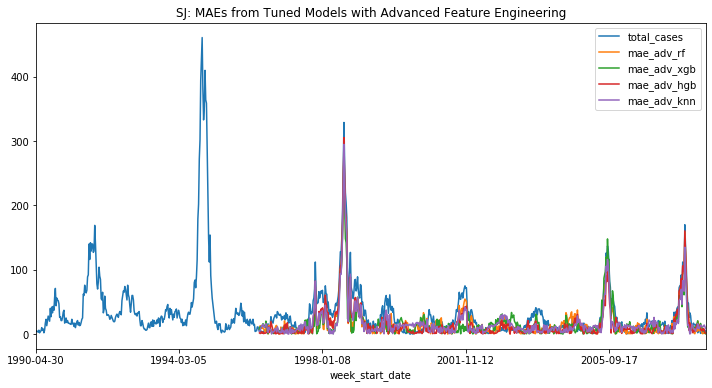

In [117]:
#Model comparison of MAE for each prediction generated through CV

model_comparison_sj = compare_models(**{'adv_rf':gscv_adv_preds_rf_sj, 'adv_xgb':gscv_adv_preds_xgb_sj, 'adv_hgb': gscv_adv_preds_hgb_sj, 'adv_knn': gscv_adv_preds_knn_sj})
model_comparison_sj[['total_cases', 'mae_adv_rf', 'mae_adv_xgb', 'mae_adv_hgb', 'mae_adv_knn', 'week_start_date']].set_index('week_start_date').plot(figsize=(12,6))
plt.title('SJ: MAEs from Tuned Models with Advanced Feature Engineering')

plt.show()

However, as the charts above show, some models perform better than others for certain predictions. We can try ensemble methods as a method to improve our predictions by using the "strengths" of each model to help in formulating a final prediction.

### Ensembles

Combining predictions from different models can potentially lead to more accurate predictions.

In [118]:
#Summary of model performances

df_sj = df.loc[df.city == 'sj']
print('Advanced HGB: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'hgb_adv'].lowest_score.values[0]))
print('Advanced XGB: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'xgb_adv'].lowest_score.values[0]))
print('Advanced RF: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'rf_adv'].lowest_score.values[0]))
print('Advanced KNN: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'knn_adv'].lowest_score.values[0]))
print('HGB: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'hgb'].lowest_score.values[0]))
print('XGB: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'xgb'].lowest_score.values[0]))
print('RF: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'rf'].lowest_score.values[0]))
print('KNN: {:.2f}'.format(df_sj.loc[df_sj.model_name == 'knn'].lowest_score.values[0]))

Advanced HGB: 16.25
Advanced XGB: 16.39
Advanced RF: 17.18
Advanced KNN: 17.24
HGB: 18.50
XGB: 21.06
RF: 20.62
KNN: 31.12


In [119]:
#Simple averages of model predictions and their respective average MAE obtained through CV

first_pred_idx_sj = gscv_adv_preds_rf_sj.loc[gscv_adv_preds_rf_sj.notnull().all(axis = 1)].index.min()

print('Averaging all advanced models: {:.2f}'.format(mean_absolute_error((gscv_adv_preds_rf_sj.loc[first_pred_idx_sj:].gscv_adv_rf_predictions + gscv_adv_preds_hgb_sj.loc[first_pred_idx_sj:].gscv_adv_hgb_predictions + gscv_adv_preds_knn_sj.loc[first_pred_idx_sj:].gscv_adv_knn_predictions + gscv_adv_preds_xgb_sj.loc[first_pred_idx_sj:].gscv_adv_xgb_predictions)/4, y_train_labels_sj.loc[first_pred_idx_sj:])))
print('Averaging all regular models: {:.2f}'.format(mean_absolute_error((gscv_xgb_preds_sj.loc[first_pred_idx_sj:].gscv_xgb_predictions + gscv_rf_preds_sj.loc[first_pred_idx_sj:].gscv_rf_predictions + gscv_knn_preds_sj.loc[first_pred_idx_sj:].gscv_knn_predictions)/3, y_train_labels_sj.loc[first_pred_idx_sj:])))
print('Averaging rf and hgb regular models: {:.2f}'.format(mean_absolute_error((gscv_hgb_preds_sj.loc[first_pred_idx_sj:].gscv_hgb_predictions + gscv_rf_preds_sj.loc[first_pred_idx_sj:].gscv_rf_predictions)/2, y_train_labels_sj.loc[first_pred_idx_sj:])))

Averaging all advanced models: 15.86
Averaging all regular models: 27.10
Averaging rf and hgb regular models: 23.53


Taking a simple average of the predictions generated through cross-validation of the models with advanced preprocessing led to a lower MAE than any of the individual models. However, we can possibly do even better if we can find the optimal balance of the models. The simplest way to do this is by applying a weighted average ensemble. 

In [120]:
#Finds all combinations of normalized (sum to 1) weights for a given number of models

def ensemble_coeffs(n_models):
    weights = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#     weights = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    weights_dict = {}
    for n in list(range(n_models)):
        weights_dict[n+1] = weights
                  
    keys = weights_dict.keys()
    values = [weights_dict[key] for key in keys]
    non_normalized_combos = [combination for combination in itertools.product(*values)]
    normalized_combos = []
    for i in non_normalized_combos:
        array = np.array(i)
        normalized_values = array / sum(array)
        normalized_combos.append(list(normalized_values))
    non_repeating_normalized_combos = []
    for j in normalized_combos:
        if (j not in non_repeating_normalized_combos and np.array(j).sum() == 1):
            non_repeating_normalized_combos.append(j)
    return non_repeating_normalized_combos

In [121]:
#Calculates a weighted average of the predictions that were generated through CV and outputs the average MAE 

def weighted_avg_ensemble(*model_preds, city):
    dot_product_preds = {}
    i = 0
    n_models = len(model_preds)
    non_repeating_normalized_combos = ensemble_coeffs(n_models)
    for weights in non_repeating_normalized_combos:
        given_weights_dict = {}
        for n in range(n_models):
            given_weights_dict[n] = weights[n] * np.array(model_preds[n])
        dot_product_preds[i] = sum(given_weights_dict.values())
        i+=1
    
    #Because cross-validation was done with TimeSeriesSplit, there are no predictions for the first fold of the data
    y = y_train_labels_sj.loc[first_pred_idx_sj:]
    
    mae_weights_dict = {}
    for l in range(len(ensemble_coeffs(len(model_preds)))):
        mae_weights_dict[l] = mean_absolute_error(dot_product_preds[l], y)
    return mae_weights_dict, non_repeating_normalized_combos

In [122]:
#Finding the weighted average of base models that leads to the lowest average MAE during cross-validation

#Advanced models
adv_models_list = ['rf_adv', 'hgb_adv', 'knn_adv', 'xgb_adv']
mae_weights_dict_adv_sj, non_repeating_normalized_combos_adv_sj = weighted_avg_ensemble(gscv_adv_preds_rf_sj.loc[first_pred_idx_sj:].gscv_adv_rf_predictions, gscv_adv_preds_hgb_sj.loc[first_pred_idx_sj:].gscv_adv_hgb_predictions, gscv_adv_preds_knn_sj.loc[first_pred_idx_sj:].gscv_adv_knn_predictions, gscv_adv_preds_xgb_sj.loc[first_pred_idx_sj:].gscv_adv_xgb_predictions, city = 'sj')

mwd_keys_adv_sj = list(mae_weights_dict_adv_sj.keys())
mwd_values_adv_sj = list(mae_weights_dict_adv_sj.values())

min_mae_adv_sj = min(mae_weights_dict_adv_sj.values())
min_mae_coeffs_adv_sj = non_repeating_normalized_combos_adv_sj[mwd_values_adv_sj.index(min_mae_adv_sj)]

#Preliminary models
reg_models_list = ['hgb', 'rf', 'knn', 'xgb']
mae_weights_dict_sj, non_repeating_normalized_combos_sj = weighted_avg_ensemble(gscv_hgb_preds_sj.loc[first_pred_idx_sj:].gscv_hgb_predictions, gscv_rf_preds_sj.loc[first_pred_idx_sj:].gscv_rf_predictions, gscv_knn_preds_sj.loc[first_pred_idx_sj:].gscv_knn_predictions, gscv_xgb_preds_sj.loc[first_pred_idx_sj:].gscv_xgb_predictions, city = 'sj')

mwd_keys_sj = list(mae_weights_dict_sj.keys())
mwd_values_sj = list(mae_weights_dict_sj.values())

min_mae_sj = min(mae_weights_dict_sj.values())
min_mae_coeffs_sj = non_repeating_normalized_combos_sj[mwd_values_sj.index(min_mae_sj)]

print('The minimum average MAE for SJ obtained by a weighted average of the advanced base predictors is {:.2f}. The coefficients are {} for {} models, respectively.'.format(min_mae_adv_sj, [round(num, 3) for num in min_mae_coeffs_adv_sj], adv_models_list))
print()
print('The minimum average MAE for SJ obtained by a weighted average of the regular base predictors is {:.2f}. The coefficients are {} for {} models, respectively.'.format(min_mae_sj, [round(num, 3) for num in min_mae_coeffs_sj], reg_models_list))

The minimum average MAE for SJ obtained by a weighted average of the advanced base predictors is 15.56. The coefficients are [0.059, 0.529, 0.0, 0.412] for ['rf_adv', 'hgb_adv', 'knn_adv', 'xgb_adv'] models, respectively.

The minimum average MAE for SJ obtained by a weighted average of the regular base predictors is 19.15. The coefficients are [0.909, 0.0, 0.0, 0.091] for ['hgb', 'rf', 'knn', 'xgb'] models, respectively.


A weighted average of the advanced preprocessed models results in the lowest average cross-validated MAE. Stacking is another ensemble method that could be applied. Because of the time series nature of the data and the advanced feature engineering, we would need to create our own meta-model, which may be explored in future analysis.

### Ideas for Further Exploration

We could continue this analysis in a couple of directions. Mainly, we could continue to better understand the relationship between `total_cases` and the input features through more EDA. Just based on a surface-level understanding of the virus, we know that climate and the spread of the disease are important predictors of `total_cases`. Exploring in greater detail what the "perfect storm" of climate featuers looks like in the weeks leading up to the current week could result in additional ideas for feature generation. 

As mentioned in the section above, we could also apply more models to see if any would perform better. Scikit-learn does not have a Negative Binomial regression model, but we could try implementing it using another module. Advanced models such as neural networks and ensemble methods such as stacking could lead to deeper pattern recognition and better results. 